# Grover\'s Algorithm
$\newcommand{\ket}[1]{\left|{#1}\right\rangle} \newcommand{\bra}[1]{\left\langle{#1}\right|}$


Grover\'s algorithm is an oracle-based quantum algorithm, proposed by Lov Grover. 
In the original description, the author approaches the following problem: suppose that we are searching for a specific phone number in a randomly-ordered catalogue containing $N$ entries. 
To find such a number with a probability of $\frac{1}{2},$ a classical algorithm will need to check the list on average $\frac{N}{2}$ times.

In other words, the problem is defined by searching for an item on a list with $N$ items given an Oracle access function $f(x).$ 
This function has the defining property that $f(x) = 1$ if $x$ is the item we are looking for, and $f(x) = 0$ otherwise. 
The solution to this black-box search problem is proposed as a quantum algorithm that performs $O(\sqrt{N})$ oracular queries to the list with a high probability of finding the answer, whereas any classical algorithm would require $O(N)$ queries.



-----------------------------------------------------
##### The problem
*Input*: A black box $U_f$ for computing an unknown function $f: \{0,1\}^n \to \{0, 1\} $

*Output*: An index $x$ such that $f(x) = 1$.

----------------------------------------------------

The algorithm can be broken down into the following steps:

1. Prepare the initial state (Apply Hadamard gates to all wires)
2. Repeat the Grover operator approximately $\frac{\pi}{4}\sqrt{N}$ times:
    - Apply the oracle
    - Apply the Grover diffusion operator
3. Apply Hadamard gates to all wires
4. Measure


We can visualize the algorithm as follows:

<img src="Image/grover circ.png"  width = 600/>

where the grover operator G is defined as:

<img src="Image/G.png" alt="Grover's operator" width = 600/>


## Defining the Oracle

Suppose we have a function $f$ representing our search problem (i.e., $f(x) = 1$ if $x$ is the solution of the search problem, $f(x) = 0$ otherwise). 

The oracle is a unitary operator $O$ acting in the following way:
$$ \ket{x}\ket{q} \to^{O} \ket{x}\ket{q \oplus f(x)} $$



### Example of an Oracle

Let us consider a simple example of an oracle that marks a particular state.


These are the oracles of the form of $f_i(x) = \begin{cases} 1 & x = i \\ 0, & x \neq i \end{cases}$ for $i = 0, 1, 2, 3$.

For instance, for two qubits we have:

<img src="Image/oracle.png" alt="Oracle" width = 600/>

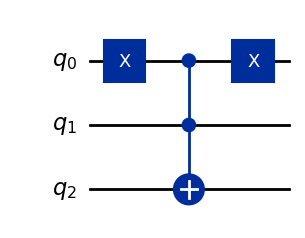

In [1]:
import numpy as np
from qiskit.circuit.library import XGate
from qiskit import QuantumCircuit

def create_f_oracle(marked, N):
    qc = QuantumCircuit(N+1, name=f"Oracle {marked}")
    marked_base2 = format(marked, f'0{N}b') 
    # reverse the order: the least significant qubit is the first one
    marked_base2 = marked_base2[::-1]
    for i in range(N): # apply the NOT gates
        if marked_base2[i] == '0':
            qc.x(i)
    # apply the multiple controlled NOT. Alternative: .mct
    qc.append(XGate().control(N), range(N+1)) 
    for i in range(N): # reverse the previous NOTs
        if marked_base2[i] == '0':
            qc.x(i)
    return qc

create_f_oracle(2, 2).draw('mpl')

We can test the oracle by applying it to a uniform superposition

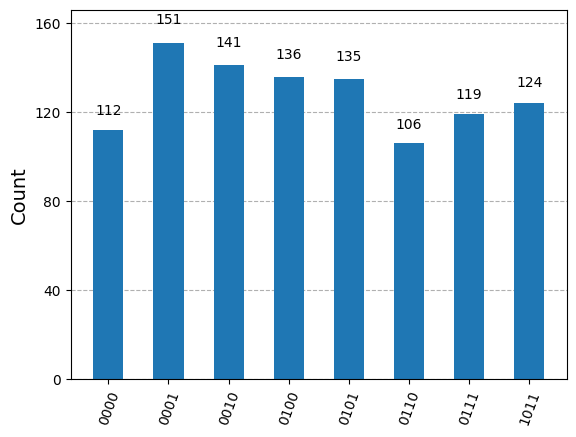

In [2]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

N = 3

num = 3

qc = QuantumCircuit(N+1)

qc.h(range(N)) # create the uniform superposition
qc.append(create_f_oracle(num, N), range(N+1)) # apply the oracle
qc.measure_all()

simulator = AerSimulator()
    
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)


## Grover Diffusion Operator

Now we need to amplificate the amplitude of the good state.

When $\ket{q} = \ket{-}$, the action of the oracle is:
$$ \ket{x}\ket{-} \to^{O} (-1)^{f(x)}\ket{x}\ket{-} $$
Thus, the action of the oracle might be written as:
$$ \ket{x} \to^{O} (-1)^{f(x)}\ket{x} $$

To perform the amplification, we need to apply the Grover diffusion operator.
The Grover diffusion operator is defined as:
$$ G = 2\ketbra{s} - I = H^{\otimes n} (2\ketbra{0}{0} - I) H^{\otimes n}$$

where $\ket{s}$ is the uniform superposition of all states.

The diffusion operator can be implemented as follows:

<img src="Image/grover_diffusion.png" alt="Diffusion operator" width = 400/>

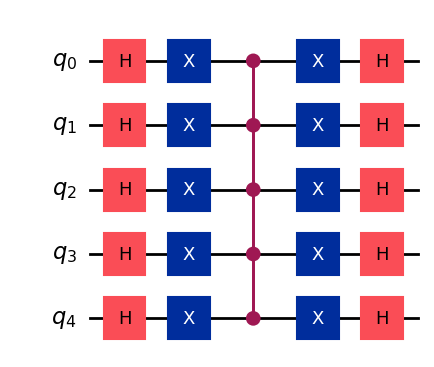

In [3]:
from qiskit.circuit.library import ZGate


def create_diffusion_operator(N):
    qc = QuantumCircuit(N, name="Diff")
    qc.h(range(N))
    qc.x(range(N))
    qc.append(ZGate().control(N-1), range(N))
    qc.x(range(N))
    qc.h(range(N))
    return qc

qc = create_diffusion_operator(5)
qc.draw('mpl')

## Putting all together

Let us now put all the pieces together and implement Grover's algorithm.

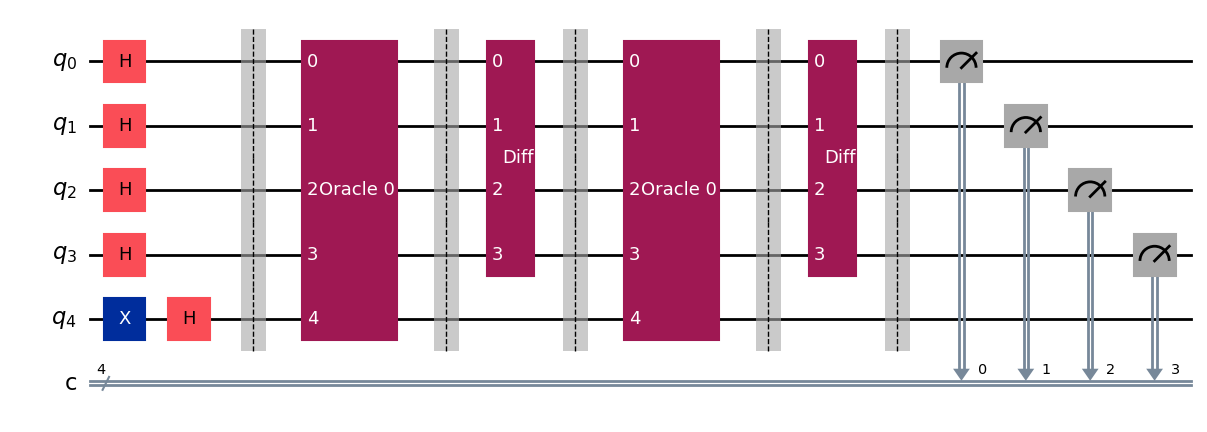

In [11]:

import math


def create_grover_circuit(num_qbits, marked):
    assert marked in range(2**num_qbits)


    grover = QuantumCircuit(num_qbits+1, num_qbits)

    grover.x(num_qbits) # create the |0> state

    grover.h(range(num_qbits+1)) # create the uniform superposition

    grover.barrier()
    
    oracle = create_f_oracle(marked, num_qbits) # Create the oracle
    
    diffusion = create_diffusion_operator(num_qbits) # Create the diffusion operator
    
    R = int(np.round(np.sqrt(num_qbits) * np.pi / 4))
    for i in range(R):
        
        grover.append(oracle, range(num_qbits+1))
        grover.barrier()
        grover.append(diffusion, range(num_qbits))
        grover.barrier()
        
    #grover.h(range(num_qbits+1)) # Apply Hadamard gates to all wires
        
    
    # grover.save_statevector()
    grover.measure(range(num_qbits), range(num_qbits))
    
    return grover



# create_grover_circuit(2,0).decompose().draw('mpl')
create_grover_circuit(4,0).draw('mpl')


Let\'s use a bar plot to better visualize the initial state amplitudes:


     ┌───┐      ░ ┌───────────┐ ░ ┌───────┐ ░ ┌───────────┐ ░ ┌───────┐ ░ ┌─┐»
q_0: ┤ H ├──────░─┤0          ├─░─┤0      ├─░─┤0          ├─░─┤0      ├─░─┤M├»
     ├───┤      ░ │           │ ░ │       │ ░ │           │ ░ │       │ ░ └╥┘»
q_1: ┤ H ├──────░─┤1          ├─░─┤1      ├─░─┤1          ├─░─┤1      ├─░──╫─»
     ├───┤      ░ │           │ ░ │       │ ░ │           │ ░ │       │ ░  ║ »
q_2: ┤ H ├──────░─┤2          ├─░─┤2 Diff ├─░─┤2          ├─░─┤2 Diff ├─░──╫─»
     ├───┤      ░ │  Oracle 2 │ ░ │       │ ░ │  Oracle 2 │ ░ │       │ ░  ║ »
q_3: ┤ H ├──────░─┤3          ├─░─┤3      ├─░─┤3          ├─░─┤3      ├─░──╫─»
     ├───┤      ░ │           │ ░ │       │ ░ │           │ ░ │       │ ░  ║ »
q_4: ┤ H ├──────░─┤4          ├─░─┤4      ├─░─┤4          ├─░─┤4      ├─░──╫─»
     ├───┤┌───┐ ░ │           │ ░ └───────┘ ░ │           │ ░ └───────┘ ░  ║ »
q_5: ┤ X ├┤ H ├─░─┤5          ├─░───────────░─┤5          ├─░───────────░──╫─»
     └───┘└───┘ ░ └───────────┘ ░           ░ └─────

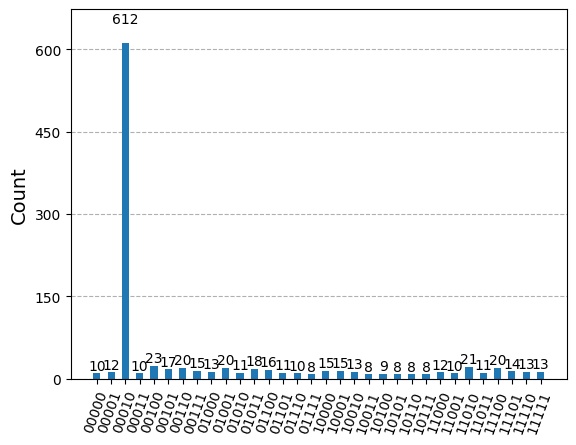

In [12]:

qc = create_grover_circuit(5,2)
print(qc.draw())
# print(qc.decompose().draw())
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
# print(result.get_statevector(circ).data)
counts = result.get_counts(circ)
plot_histogram(counts)

Useful links: [https://averyparkinson23.medium.com/solving-sudoku-using-quantum-computing-cbc8a397a504](https://averyparkinson23.medium.com/solving-sudoku-using-quantum-computing-cbc8a397a504)